In [1]:
# Import manipulating files libraries
import os, glob
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   #if like me you do not have a lot of memory in your GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "" #then these two lines force keras to use your CPU
# Import graph/image plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Import loading and manipulating neuroimaging data library
import nibabel as nib

# Import array manipulating libraries
import numpy as np
import pandas as pd

# Import deep learning model libraries
import tensorflow as tf
import keras
from keras.models import Model, Sequential

from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# Import date/time library to save models with date/time
from datetime import datetime

In [2]:
# Get data path
data_path = 'final data/*.nii.gz'
# Find all files within the location that matches our search string
files = glob.glob(data_path)

# Get the labels for our data from our csv file
Labels = pd.read_csv('labels.csv')
# Define our target from the column "Labels" as our y in our model
target = Labels['group']

In [3]:
# Loop through files and load all data files
data_all, images = [], []
for data_file in sorted(files):
    data = nib.load(data_file).get_fdata()
    first_vol = data[:,:,:,0]
    first = first_vol / 255
    data_all.append(first)
    
# Convert our list into a numpy array
images = np.asarray(data_all)

print(len(data_all))
print (np.shape(images))

120
(120, 64, 64, 34)


In [4]:
print(images[3])

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.03921569 0.04705882 0.05098039 ... 0.03529412 0.04313725 0.03137255]
  [0.03921569 0.03529412 0.05098039 ... 0.04313725 0.03529412 0.04313725]
  [0.04705882 0.05098039 0.04313725 ... 0.05098039 0.03529412 0.04313725]
  ...
  [0.0745098  0.09411765 0.10196078 ... 0.05882353 0.05098039 0.05882353]
  [0.08235294 0.06666667 0.09411765 ... 0.05098039 0.05098039 0.05490196]
  [0.07058824 0.0745098  0.09019608 ... 0.05490196 0.05490196 0.05882353]]

 [[0.03921569 0.05098039 0.06666667 ... 0.05098039 0.03921569 0.03921569]
  [0.04705882 0.054901

In [5]:
# Create list of indices
N = images.shape[0]
indexes = np.arange(N)

# Divide our dataset into dyslexics and controls to have a balanced train, validation and test sets
dis = indexes[:60]
con = indexes[60:]

#  Cut the dataset at 80% to create the training, 10% validation and 10% test set
size = dis.shape[0]
split_1 = int(0.7 * size)
split_2 = int(0.85 * size)

# Shuffle our dyslexics and controls arrays to create random indexes
np.random.shuffle(np.asarray(dis))
np.random.shuffle(np.asarray(con))

# Create our indexes for our train, validation and test sets according to our previous division (80%, 10%, 10%)
indexes_train_dis, indexes_train_con = dis[:split_1], con[:split_1]
indexes_val_dis, indexes_val_con   = dis[split_1:split_2], con[split_1:split_2]
indexes_test_dis, indexes_test_con = dis[split_2:], con[split_2:]

# We concatenate our training, validation and test indexes for dyslexics and controls
# By doing that we ensure that each set is balanced with the same number of dyslexics and controls
indexes_train = np.concatenate((indexes_train_dis, indexes_train_con), axis=None)
indexes_val = np.concatenate((indexes_val_dis, indexes_val_con), axis=None)
indexes_test = np.concatenate((indexes_test_dis, indexes_test_con), axis=None)


# Split the data into training, validation and test sets according to the indexes created previously
X_train = images[indexes_train, ...]
X_val = images[indexes_val, ...]
X_test = images[indexes_test, ...]
print(X_train.shape, X_val.shape,X_test.shape)

(84, 64, 64, 34) (18, 64, 64, 34) (18, 64, 64, 34)


In [6]:
print(indexes_train_dis.shape, indexes_train_con.shape)
print(indexes_val_dis.shape, indexes_val_con.shape)
print(indexes_test_dis.shape, indexes_test_con.shape)

(42,) (42,)
(9,) (9,)
(9,) (9,)


In [7]:
# Create outcome variable for each set (training, validation and test)
y_train = target[indexes_train] 
y_val   = target[indexes_val]
y_test  = target[indexes_test]
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(84, 64, 64, 34)
(18, 64, 64, 34)
(18, 64, 64, 34)
(84,)
(18,)
(18,)


In [8]:
# Our vectorized labels
y_train = np.asarray(y_train).astype('int32')
y_test = np.asarray(y_test).astype('int32')
y_val = np.asarray(y_val).astype('int32')

In [9]:
x_train = X_train.reshape(len(X_train), -1)
print(x_train.shape)
x_test = X_test.reshape(len(X_test), -1)
print(x_test.shape)
x_val = X_val.reshape(len(X_val), -1)
print(x_val.shape)

(84, 139264)
(18, 139264)
(18, 139264)


In [10]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train1 = sc.fit_transform(x_train)
x_test1 = sc.transform(x_test)
x_val1 = sc.transform(x_val)
x_val1

array([[ 0.        ,  0.        ,  0.        , ..., -0.11356306,
         0.27541006,  1.30103469],
       [ 0.        ,  0.        ,  0.        , ...,  1.79429641,
         1.75207678,  0.29840245],
       [ 0.        ,  0.        ,  0.        , ..., -0.59052793,
         0.27541006, -0.70422979],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -1.54445767,
        -1.20125665, -1.70686203],
       [ 0.        ,  0.        ,  0.        , ..., -0.59052793,
        -0.70903441, -1.70686203],
       [ 0.        ,  0.        ,  0.        , ..., -1.0674928 ,
        -0.21681218, -1.20554591]])

In [11]:
x_test1.shape

(18, 139264)

In [12]:
print(x_test1)

[[ 0.          0.          0.         ...  0.84036667  0.27541006
  -0.20291367]
 [ 0.          0.          0.         ... -0.59052793  0.27541006
  -0.70422979]
 [ 0.          0.          0.         ... -0.59052793  0.27541006
   1.30103469]
 ...
 [ 0.          0.          0.         ...  0.84036667  1.25985454
   1.80235081]
 [ 0.          0.          0.         ...  0.3634018   0.27541006
   1.30103469]
 [ 0.          0.          0.         ... -0.59052793  0.27541006
  -0.70422979]]


In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(solver='svd', shrinkage=None, priors=None, n_components=1, store_covariance=False, tol=0.0001)
x_train1 = lda.fit_transform(x_train1, y_train)
x_test1 = lda.transform(x_test1)
x_val1 = lda.transform(x_val1)

In [14]:
x_train1

array([[-1.18784873],
       [ 2.2864537 ],
       [-1.37450918],
       [-0.73781233],
       [-1.00827297],
       [-1.36411929],
       [-0.26394675],
       [-1.73446668],
       [-0.28814398],
       [-1.78184287],
       [-0.70970967],
       [-0.83589438],
       [-1.73853425],
       [-1.3454354 ],
       [-0.32057229],
       [-0.08300359],
       [-0.85905023],
       [ 1.39614409],
       [-1.14378363],
       [-0.91828412],
       [-1.4986793 ],
       [-1.98349517],
       [-0.84741007],
       [ 2.09075106],
       [ 1.13198744],
       [-2.12016114],
       [-0.99847657],
       [-1.22953745],
       [-1.30148259],
       [-0.70109477],
       [-1.28335163],
       [ 2.13679255],
       [-1.39541557],
       [-0.94957971],
       [-1.20739978],
       [-0.61600901],
       [-0.51240537],
       [-1.22612362],
       [-1.07533745],
       [-1.38898903],
       [-1.33247353],
       [-1.0884526 ],
       [ 0.46388877],
       [ 1.27885804],
       [ 1.21523736],
       [-3

In [15]:
# import SVC classifier
from sklearn.svm import SVC


# import metrics to compute accuracy
from sklearn.metrics import accuracy_score


# instantiate classifier with default hyperparameters
svc=SVC() 


# fit classifier to training set
svc.fit(x_train1,y_train)


# make predictions on test set
y_pred=svc.predict(x_test1)


# compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with default hyperparameters: 0.7222


In [16]:
# Analyze prediction values

predicted = svc.predict(x_test1)
predicted[:]

array([0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1])

In [17]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [18]:
cm = tf.math.confusion_matrix(labels = y_test, predictions= predicted)
print(cm)

tf.Tensor(
[[6 3]
 [2 7]], shape=(2, 2), dtype=int32)


Text(92.25, 0.5, 'Truth')

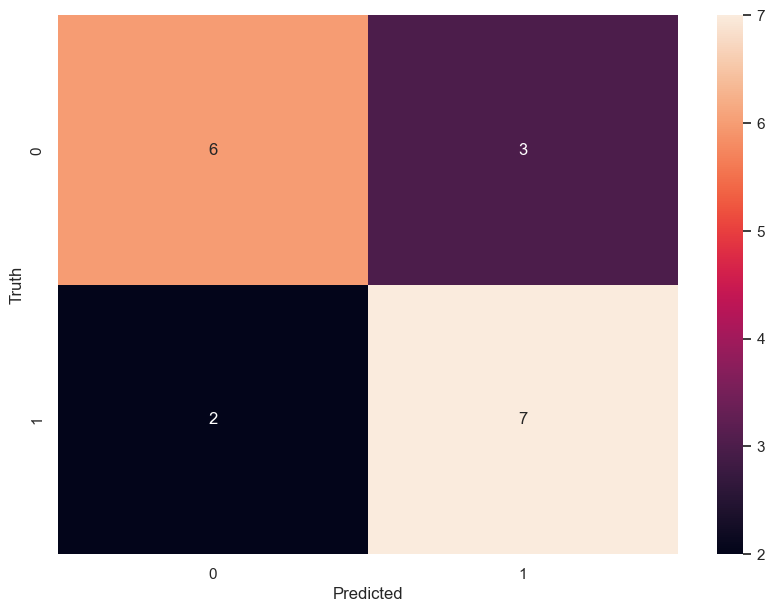

In [19]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [20]:
predicted = tf.one_hot(predicted, 2)


In [21]:
predicted

<tf.Tensor: shape=(18, 2), dtype=float32, numpy=
array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)>

In [22]:
# Import confusion matrix and classification report from scikit-learn
from sklearn.metrics import confusion_matrix, classification_report
Y_prediction = svc.predict(x_test1)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(predicted,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(target[indexes_test], Y_pred_classes) 
print(classification_report(target[indexes_test], Y_pred_classes))

              precision    recall  f1-score   support

           0       0.75      0.67      0.71         9
           1       0.70      0.78      0.74         9

    accuracy                           0.72        18
   macro avg       0.72      0.72      0.72        18
weighted avg       0.73      0.72      0.72        18



In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve, auc

C:\Users\achin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


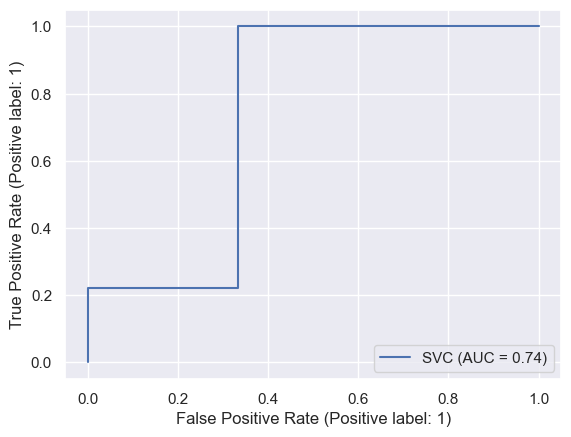

In [24]:
plot_roc_curve(svc, x_test1, y_test)